In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import numpy as np
import pandas as pd
import collections

In [2]:
x_name = os.path.join(os.getcwd(), '데이터SET', f"{'[Track1_데이터3] samp_cst_feat'}.csv")
df_x = pd.read_csv(x_name, index_col=0)

y_name = os.path.join(os.getcwd(), '데이터SET', f"{'[Track1_데이터2] samp_train'}.csv")
df_y = pd.read_csv(y_name, index_col=0)

df = pd.merge(df_x, df_y, on='cst_id_di')

In [3]:
df.MRC_ID_DI[df.MRC_ID_DI > 0 ] = 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [4]:
nc_name = os.path.join(os.getcwd(), '데이터SET', f"{'[Track1_데이터4] variable_dtype'}.xlsx")
nc = pd.read_excel(nc_name, index_col=0)

In [5]:
from  sklearn.preprocessing import scale
from statsmodels.nonparametric.kde import KDEUnivariate

def find_outliers_kde(x):
    x_scaled = scale(list(map(float, x)))
    kde = KDEUnivariate(x_scaled)
    kde.fit(bw='scott', fft=True)
    pred = kde.evaluate(x_scaled)
    
    n = sum(pred < 0.001)
    outlier_ind = np.asarray(pred).argsort()[:n]
    outlier_value = np.asarray(x)[outlier_ind]
    
    return outlier_ind, outlier_value

for i in df.columns[0:-1]:
    if nc.loc[i, 'dType'] == 'numerical':
        kde_indices, kde_values = find_outliers_kde(df[i])
        df_01 = df[i].quantile(0.01)
        df_99 = df[i].quantile(0.99)
        df_50 = df[i].quantile(0.50)
        for j in range(len(df)):
            if df[i].values[j] in kde_values:
                df.at[df.index[j], i] = df_50
"""
for i in df.columns[0:-1]:
    if nc.loc[i, 'dType'] == 'numerical':
        d_90 = df[i].quantile(0.99)
        d_10 = df[i].quantile(0.01)
        d_50 = df[i].quantile(0.50)
        df[i] = np.where(df[i] > d_90, d_90, df[i])
        df[i] = np.where(df[i] < d_10, d_10, df[i])
"""

print(df.shape)
#(10124, 227)

(10124, 227)


In [6]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [7]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [232]:
df_0 = df[df['MRC_ID_DI'] == 0].sample(frac=1)
df_1 = df[df['MRC_ID_DI'] == 1].sample(frac=1)

sample_size = len(df_0) if len(df_0) < len(df_1) else len(df_1)

df_h = pd.concat([df_0.head(sample_size), df_1.head(sample_size)]).sample(frac=1)
df_t = pd.concat([df_0.tail(sample_size), df_1.head(sample_size)]).sample(frac=1)
df_f = pd.concat([df_h, df_t]).sample(frac=1)

In [233]:
X = df_f.drop(columns = ['MRC_ID_DI'], axis=1)
#X = df_f.drop(columns = ['MRC_ID_DI', 'VAR021', 'VAR046'], axis=1)
#y = tf.keras.utils.to_categorical(df_f['MRC_ID_DI'])
y = df_f['MRC_ID_DI']

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [235]:
num, cat = list(), list()
for i in X.columns:
    if nc.loc[i, 'dType'] == 'numerical':
        num.append(i)
    else:
        cat.append(i)


X1_train = X_train[num]
X1_test = X_test[num]

X2_train = X_train[cat]
X2_test = X_test[cat]

In [236]:
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

def add_interactions(df1, df2):
    df = pd.concat([df1, df2])
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]
    
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis = 1)
    return df[:len(df1)], df[len(df1):]

X1_train, X1_test = add_interactions(X1_train, X1_test)
X2_train, X2_test = add_interactions(X2_train, X2_test)

In [237]:
"""
import sklearn.feature_selection

select = sklearn.feature_selection.SelectKBest(k=len(X1_train.columns)//8)
selected_features = select.fit(X1_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X1_train.columns[i] for i in indices_selected]

X1_train = X1_train[colnames_selected]
X1_test = X1_test[colnames_selected]

select = sklearn.feature_selection.SelectKBest(k=len(X2_train.columns)//8)
selected_features = select.fit(X2_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X2_train.columns[i] for i in indices_selected]

X2_train = X2_train[colnames_selected]
X2_test = X2_test[colnames_selected]
"""

'\nimport sklearn.feature_selection\n\nselect = sklearn.feature_selection.SelectKBest(k=len(X1_train.columns)//8)\nselected_features = select.fit(X1_train, y_train)\nindices_selected = selected_features.get_support(indices=True)\ncolnames_selected = [X1_train.columns[i] for i in indices_selected]\n\nX1_train = X1_train[colnames_selected]\nX1_test = X1_test[colnames_selected]\n\nselect = sklearn.feature_selection.SelectKBest(k=len(X2_train.columns)//8)\nselected_features = select.fit(X2_train, y_train)\nindices_selected = selected_features.get_support(indices=True)\ncolnames_selected = [X2_train.columns[i] for i in indices_selected]\n\nX2_train = X2_train[colnames_selected]\nX2_test = X2_test[colnames_selected]\n'

In [238]:
from sklearn.decomposition import PCA
pca = PCA(n_components=min(len(pd.concat([X1_train, X1_test])), len(X1_train.columns)//8))
X_t = pd.DataFrame(pca.fit_transform(pd.concat([X1_train, X1_test])))
X1_train, X1_test = X_t[:len(X1_train)], X_t[len(X1_train):]

pca = PCA(n_components=len(X2_train.columns)//8)
X_t = pd.DataFrame(pca.fit_transform(pd.concat([X2_train, X2_test])))
X2_train, X2_test = X_t[:len(X2_train)], X_t[len(X2_train):]

In [239]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [240]:
input_1 = tf.keras.Input(dtype = tf.float32, shape = (len(X1_train.columns),))
input_2 = tf.keras.Input(dtype = tf.float32, shape = (len(X2_train.columns),))

dense_layer_1_1 = tf.keras.layers.Dense(units = 64, activation = tf.nn.relu)(input_1)
dropout_1_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_1_1)


dense_layer_2_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_2)
dropout_2_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_2_1)

concat_layer = tf.keras.layers.Concatenate()([dropout_1_5, dropout_2_5])


dense_layer_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(concat_layer)
dropout_3_5 = tf.keras.layers.Dropout(rate = 0.8)(dense_layer_3)

#output = tf.keras.layers.Dense(units = 2, activation = tf.nn.softmax)(dense_layer_3)
output = tf.keras.layers.Dense(units = 2, activation = tf.nn.softmax)(dropout_3_5)

In [241]:
model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)

In [242]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001), metrics=['acc'])
print(model.summary())

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 2462)]       0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 41)]         0                                            
__________________________________________________________________________________________________
dense_64 (Dense)                (None, 64)           157632      input_33[0][0]                   
__________________________________________________________________________________________________
dense_65 (Dense)                (None, 10)           420         input_34[0][0]                   
___________________________________________________________________________________________

In [243]:
#history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=400, verbose=1, validation_split=0.1)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)
history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=32, epochs=2000, verbose=1, validation_split=0.1, callbacks=[callback])

Train on 6233 samples, validate on 693 samples
Epoch 1/2000
6233/6233 [==============================] - 1s 162us/sample - loss: 0.9133 - acc: 0.4964 - val_loss: 0.7318 - val_acc: 0.4834
Epoch 2/2000
6233/6233 [==============================] - 0s 73us/sample - loss: 0.9224 - acc: 0.4868 - val_loss: 0.7166 - val_acc: 0.5036
Epoch 3/2000
6233/6233 [==============================] - 0s 74us/sample - loss: 0.8987 - acc: 0.4847 - val_loss: 0.7029 - val_acc: 0.5310
Epoch 4/2000
6233/6233 [==============================] - 0s 76us/sample - loss: 0.8610 - acc: 0.4937 - val_loss: 0.6912 - val_acc: 0.5440
Epoch 5/2000
6233/6233 [==============================] - 0s 73us/sample - loss: 0.8550 - acc: 0.4877 - val_loss: 0.6801 - val_acc: 0.5628
Epoch 6/2000
6233/6233 [==============================] - 0s 76us/sample - loss: 0.8195 - acc: 0.5140 - val_loss: 0.6705 - val_acc: 0.5830
Epoch 7/2000
6233/6233 [==============================] - 0s 71us/sample - loss: 0.8107 - acc: 0.5150 - val_loss: 0.66

6233/6233 [==============================] - 0s 74us/sample - loss: 0.6246 - acc: 0.6238 - val_loss: 0.5508 - val_acc: 0.7792
Epoch 60/2000
6233/6233 [==============================] - 0s 73us/sample - loss: 0.6200 - acc: 0.6288 - val_loss: 0.5495 - val_acc: 0.7807
Epoch 61/2000
6233/6233 [==============================] - 0s 71us/sample - loss: 0.6160 - acc: 0.6345 - val_loss: 0.5483 - val_acc: 0.7792
Epoch 62/2000
6233/6233 [==============================] - 0s 73us/sample - loss: 0.6247 - acc: 0.6254 - val_loss: 0.5473 - val_acc: 0.7792
Epoch 63/2000
6233/6233 [==============================] - 0s 77us/sample - loss: 0.6164 - acc: 0.6324 - val_loss: 0.5462 - val_acc: 0.7792
Epoch 64/2000
6233/6233 [==============================] - 0s 72us/sample - loss: 0.6281 - acc: 0.6271 - val_loss: 0.5453 - val_acc: 0.7807
Epoch 65/2000
6233/6233 [==============================] - 0s 74us/sample - loss: 0.6086 - acc: 0.6419 - val_loss: 0.5438 - val_acc: 0.7792
Epoch 66/2000
6233/6233 [=========

6233/6233 [==============================] - 0s 72us/sample - loss: 0.5884 - acc: 0.6653 - val_loss: 0.4980 - val_acc: 0.7807
Epoch 118/2000
6233/6233 [==============================] - 0s 72us/sample - loss: 0.5793 - acc: 0.6725 - val_loss: 0.4971 - val_acc: 0.7821
Epoch 119/2000
6233/6233 [==============================] - 0s 72us/sample - loss: 0.5861 - acc: 0.6652 - val_loss: 0.4965 - val_acc: 0.7821
Epoch 120/2000
6233/6233 [==============================] - 0s 73us/sample - loss: 0.5749 - acc: 0.6717 - val_loss: 0.4954 - val_acc: 0.7821
Epoch 121/2000
6233/6233 [==============================] - 0s 72us/sample - loss: 0.5826 - acc: 0.6671 - val_loss: 0.4949 - val_acc: 0.7821
Epoch 122/2000
6233/6233 [==============================] - 0s 75us/sample - loss: 0.5819 - acc: 0.6668 - val_loss: 0.4941 - val_acc: 0.7821
Epoch 123/2000
6233/6233 [==============================] - 0s 71us/sample - loss: 0.5780 - acc: 0.6722 - val_loss: 0.4935 - val_acc: 0.7821
Epoch 124/2000
6233/6233 [==

6233/6233 [==============================] - 0s 71us/sample - loss: 0.5436 - acc: 0.7016 - val_loss: 0.4587 - val_acc: 0.7951
Epoch 176/2000
6233/6233 [==============================] - 0s 73us/sample - loss: 0.5425 - acc: 0.7066 - val_loss: 0.4581 - val_acc: 0.7951
Epoch 177/2000
6233/6233 [==============================] - 0s 72us/sample - loss: 0.5463 - acc: 0.7016 - val_loss: 0.4579 - val_acc: 0.7965
Epoch 178/2000
6233/6233 [==============================] - 0s 72us/sample - loss: 0.5371 - acc: 0.7136 - val_loss: 0.4572 - val_acc: 0.7965
Epoch 179/2000
6233/6233 [==============================] - 0s 75us/sample - loss: 0.5401 - acc: 0.7016 - val_loss: 0.4563 - val_acc: 0.7965
Epoch 180/2000
6233/6233 [==============================] - 0s 73us/sample - loss: 0.5364 - acc: 0.7074 - val_loss: 0.4558 - val_acc: 0.7965
Epoch 181/2000
6233/6233 [==============================] - 0s 74us/sample - loss: 0.5323 - acc: 0.7106 - val_loss: 0.4551 - val_acc: 0.7965
Epoch 182/2000
6233/6233 [==

6233/6233 [==============================] - 0s 74us/sample - loss: 0.5060 - acc: 0.7340 - val_loss: 0.4275 - val_acc: 0.8066
Epoch 234/2000
6233/6233 [==============================] - 0s 71us/sample - loss: 0.5027 - acc: 0.7446 - val_loss: 0.4271 - val_acc: 0.8038
Epoch 235/2000
6233/6233 [==============================] - 0s 73us/sample - loss: 0.4984 - acc: 0.7367 - val_loss: 0.4267 - val_acc: 0.8052
Epoch 236/2000
6233/6233 [==============================] - 0s 77us/sample - loss: 0.4909 - acc: 0.7465 - val_loss: 0.4262 - val_acc: 0.8052
Epoch 237/2000
6233/6233 [==============================] - 0s 73us/sample - loss: 0.5020 - acc: 0.7417 - val_loss: 0.4258 - val_acc: 0.8066
Epoch 238/2000
6233/6233 [==============================] - 0s 73us/sample - loss: 0.4946 - acc: 0.7431 - val_loss: 0.4252 - val_acc: 0.8066
Epoch 239/2000
6233/6233 [==============================] - 0s 75us/sample - loss: 0.5058 - acc: 0.7382 - val_loss: 0.4247 - val_acc: 0.8066
Epoch 240/2000
6233/6233 [==

6233/6233 [==============================] - 0s 72us/sample - loss: 0.4664 - acc: 0.7685 - val_loss: 0.4030 - val_acc: 0.8153
Epoch 292/2000
6233/6233 [==============================] - 0s 74us/sample - loss: 0.4674 - acc: 0.7695 - val_loss: 0.4026 - val_acc: 0.8167
Epoch 293/2000
6233/6233 [==============================] - 0s 73us/sample - loss: 0.4581 - acc: 0.7738 - val_loss: 0.4021 - val_acc: 0.8167
Epoch 294/2000
6233/6233 [==============================] - 0s 75us/sample - loss: 0.4678 - acc: 0.7621 - val_loss: 0.4017 - val_acc: 0.8139
Epoch 295/2000
6233/6233 [==============================] - 0s 71us/sample - loss: 0.4682 - acc: 0.7715 - val_loss: 0.4014 - val_acc: 0.8153
Epoch 296/2000
6233/6233 [==============================] - 0s 72us/sample - loss: 0.4564 - acc: 0.7805 - val_loss: 0.4009 - val_acc: 0.8139
Epoch 297/2000
6233/6233 [==============================] - 0s 71us/sample - loss: 0.4669 - acc: 0.7706 - val_loss: 0.4007 - val_acc: 0.8153
Epoch 298/2000
6233/6233 [==

6233/6233 [==============================] - 0s 74us/sample - loss: 0.4222 - acc: 0.7919 - val_loss: 0.3831 - val_acc: 0.8326
Epoch 350/2000
6233/6233 [==============================] - 0s 74us/sample - loss: 0.4315 - acc: 0.7910 - val_loss: 0.3827 - val_acc: 0.8341
Epoch 351/2000
6233/6233 [==============================] - 0s 74us/sample - loss: 0.4364 - acc: 0.7842 - val_loss: 0.3824 - val_acc: 0.8341
Epoch 352/2000
6233/6233 [==============================] - 0s 75us/sample - loss: 0.4337 - acc: 0.7956 - val_loss: 0.3821 - val_acc: 0.8341
Epoch 353/2000
6233/6233 [==============================] - 0s 72us/sample - loss: 0.4306 - acc: 0.7874 - val_loss: 0.3818 - val_acc: 0.8341
Epoch 354/2000
6233/6233 [==============================] - 0s 74us/sample - loss: 0.4367 - acc: 0.7866 - val_loss: 0.3813 - val_acc: 0.8341
Epoch 355/2000
6233/6233 [==============================] - 0s 72us/sample - loss: 0.4314 - acc: 0.7850 - val_loss: 0.3811 - val_acc: 0.8341
Epoch 356/2000
6233/6233 [==

6233/6233 [==============================] - 0s 75us/sample - loss: 0.3952 - acc: 0.8100 - val_loss: 0.3668 - val_acc: 0.8369
Epoch 408/2000
6233/6233 [==============================] - 0s 78us/sample - loss: 0.4007 - acc: 0.8083 - val_loss: 0.3666 - val_acc: 0.8384
Epoch 409/2000
6233/6233 [==============================] - 0s 74us/sample - loss: 0.4001 - acc: 0.8185 - val_loss: 0.3664 - val_acc: 0.8384
Epoch 410/2000
6233/6233 [==============================] - 0s 72us/sample - loss: 0.3974 - acc: 0.8115 - val_loss: 0.3665 - val_acc: 0.8384
Epoch 411/2000
6233/6233 [==============================] - 0s 74us/sample - loss: 0.3993 - acc: 0.8133 - val_loss: 0.3665 - val_acc: 0.8398
Epoch 412/2000
6233/6233 [==============================] - 0s 74us/sample - loss: 0.3937 - acc: 0.8173 - val_loss: 0.3666 - val_acc: 0.8384
Epoch 413/2000
6233/6233 [==============================] - 0s 73us/sample - loss: 0.3937 - acc: 0.8144 - val_loss: 0.3661 - val_acc: 0.8384
Epoch 414/2000
6233/6233 [==

6233/6233 [==============================] - 0s 74us/sample - loss: 0.3627 - acc: 0.8293 - val_loss: 0.3557 - val_acc: 0.8470
Epoch 466/2000
6233/6233 [==============================] - 0s 74us/sample - loss: 0.3671 - acc: 0.8234 - val_loss: 0.3557 - val_acc: 0.8470
Epoch 467/2000
6233/6233 [==============================] - 0s 73us/sample - loss: 0.3635 - acc: 0.8303 - val_loss: 0.3556 - val_acc: 0.8442
Epoch 468/2000
6233/6233 [==============================] - 0s 73us/sample - loss: 0.3668 - acc: 0.8315 - val_loss: 0.3555 - val_acc: 0.8427
Epoch 469/2000
6233/6233 [==============================] - 0s 72us/sample - loss: 0.3697 - acc: 0.8254 - val_loss: 0.3555 - val_acc: 0.8442
Epoch 470/2000
6233/6233 [==============================] - 0s 73us/sample - loss: 0.3683 - acc: 0.8299 - val_loss: 0.3556 - val_acc: 0.8442
Epoch 471/2000
6233/6233 [==============================] - 0s 75us/sample - loss: 0.3649 - acc: 0.8354 - val_loss: 0.3552 - val_acc: 0.8427
Epoch 472/2000
6233/6233 [==

6233/6233 [==============================] - 0s 72us/sample - loss: 0.3393 - acc: 0.8487 - val_loss: 0.3518 - val_acc: 0.8456
Epoch 524/2000
6233/6233 [==============================] - 0s 74us/sample - loss: 0.3391 - acc: 0.8405 - val_loss: 0.3518 - val_acc: 0.8470
Epoch 525/2000
6233/6233 [==============================] - 0s 74us/sample - loss: 0.3355 - acc: 0.8413 - val_loss: 0.3519 - val_acc: 0.8470
Epoch 526/2000
6233/6233 [==============================] - 0s 75us/sample - loss: 0.3476 - acc: 0.8341 - val_loss: 0.3518 - val_acc: 0.8456
Epoch 527/2000
6233/6233 [==============================] - 0s 72us/sample - loss: 0.3346 - acc: 0.8473 - val_loss: 0.3514 - val_acc: 0.8470
Epoch 528/2000
6233/6233 [==============================] - 0s 74us/sample - loss: 0.3371 - acc: 0.8420 - val_loss: 0.3512 - val_acc: 0.8442
Epoch 529/2000
6233/6233 [==============================] - 0s 72us/sample - loss: 0.3337 - acc: 0.8477 - val_loss: 0.3515 - val_acc: 0.8456
Epoch 530/2000
6233/6233 [==

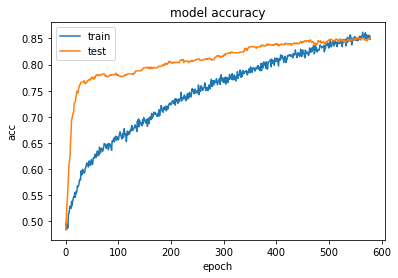

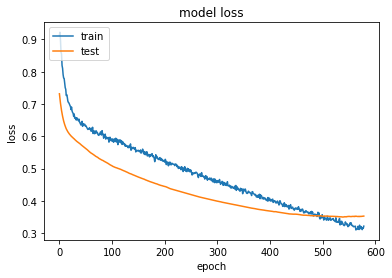

In [244]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [245]:
score = model.evaluate(x=[X1_test, X2_test], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test ACC:", score[1])

770/770 [==============================] - 0s 56us/sample - loss: 0.4335 - acc: 0.8312
Test Score: 0.4335043683454588
Test ACC: 0.83116883
